<a href="https://colab.research.google.com/github/raultyv/Machine_learning/blob/main/RF_plan_mensual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## 1. CARGA DEL DATASET
import pandas as pd #basico para trabajar data tabular como en excel
import numpy as np # usado para calculos numericos
from google.colab import files #permite subir archivos manualmente

uploaded = files.upload() #para subir archivos
filename = list(uploaded.keys())[0] #extrae el nombre del primer archivo subido
df = pd.read_excel(filename) #lee el excel data y crea un data frame
df.head() #visualizacion de las primeras 5 filas,  verifica que se ha cargado la data

## 2. ESTANDARIZACIÓN Y TIPOS
df.columns = [c.replace('Real Diario', 'Fecha').replace(' ', '_').replace('(', '').replace(')', '').replace('%', 'Pct').replace('.', '') for c in df.columns] #para normalizar nombres de columnas, sin espacios, sin simbolos

for col in df.columns:
    if col != 'Fecha': #evita tocar la fecha
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce') #fuerza y limpia todas las variables (salvo la fecha) a numericas
        #primero convierte todo a string, permite aplicar el str.replace (util cuando la data mezcla numero y texto), convertimos a formato europeo de 0,2  a 0.2 todos los datos, pd.numeric convierte a numero, si no puede pone NaN

## 3. UNIFICACIÓN DE ESCALAS Y UNIDADES (Lo que ya validamos)
cols_pct = [c for c in df.columns if 'Pct' in c or 'Ley' in c or 'Rec' in c or 'Tox' in c] #lista de nombres con variables que representan porcentajes
for col in cols_pct:
    df[col] = np.where(df[col] > 1.1, df[col] / 100.0, df[col]) #normalizacion automatica, evita porcentajes mayores a 100% (absurdos)

# Sincronizar Fino Recuperado con Filtrado (x100)
if df['Cu_Fino_Recuperado_t'].mean() < 50: # si la variables tiene un promedio menor, se asume que esta en otra escala o en cientos de toneladas (en este caso)
    df['Cu_Fino_Recuperado_t'] = df['Cu_Fino_Recuperado_t'] * 100.0 #escala la variable

## 4. ELIMINACIÓN DE NULOS Y OUTLIERS FÍSICOS (Sin completar nada)
# Eliminamos cualquier día con datos faltantes (paradas de planta)
df_limpio = df.dropna().copy()

# Filtramos errores de sensor/digitación obvios que detectamos en el describe
df_limpio = df_limpio[
    (df_limpio['Ley_Pct'] <= 0.05) & # No existe ley de alimentación de 103% (1.03)
    (df_limpio['Tonelaje_Stock_Pile_Kt'] < 3000) & # Filtramos el stock pile de 9000
    (df_limpio['Rec_Pct'] > 0.1) # Si la recuperación es casi 0, no hay proceso real
]

print(f"Días con operación completa y válida: {len(df_limpio)}")
print("\n--- Estadísticas Finales para ML ---")
print(df_limpio.describe())

df_limpio.describe()
## conclusion: se observa un -10 en el stock pile lo cual no es correcto

## correccion
# Eliminamos las filas donde el Stock Pile sea negativo antes de cerrar el modelo
df_limpio = df_limpio[df_limpio['Tonelaje_Stock_Pile_Kt'] >= 0]

# Verificamos que el mínimo ahora sea 0 o superior
print(f"Nuevo mínimo de Stock Pile: {df_limpio['Tonelaje_Stock_Pile_Kt'].min()}")
print(df_limpio.describe())
## conclusion: verificado, correcto, no se esta imputando, se esta eliminando filas donde no hay procesos para ML predictivo.
df_limpio.head()

In [ ]:
## EDA de las variables

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('seaborn-v0_8-muted')
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

variables = [
    ('Ley_Pct', 'Distribución de Ley de Alimentación (%)'),
    ('Molido_Kt', 'Distribución de Molienda (Kt/día)'),
    ('Rec_Pct', 'Distribución de Recuperación (%)'),
    ('Tox_Pct', 'Distribución de Elementos Tóxicos (%)')
]

for ax, (col, title) in zip(axs.flatten(), variables): #histogramas
    sns.histplot(
        df_limpio[col],
        kde=True,
        bins=20,
        ax=ax
    )

    media = df_limpio[col].mean()
    mediana = df_limpio[col].median()

    ax.axvline(media, color='black', linestyle='--', label=f'Media: {media:.2f}')
    ax.axvline(mediana, color='red', linestyle='-', label=f'Mediana: {mediana:.2f}')

    ax.set_title(title)
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
## boxplots
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_limpio[['Ley_Pct', 'Molido_Kt', 'Rec_Pct', 'Tox_Pct']])
plt.title('Boxplots – Identificación de Outliers Operativos')
plt.ylabel('Valor')
plt.grid(alpha=0.3)
plt.show()


In [ ]:
## ley vs recuperacion
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=df_limpio,
    x='Ley_Pct',
    y='Rec_Pct'
)
plt.title('Ley vs Recuperación')
plt.grid(alpha=0.3)
plt.show()


In [ ]:
#molido vs recuperacion
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=df_limpio,
    x='Molido_Kt',
    y='Rec_Pct'
)
plt.title('Molienda vs Recuperación')
plt.grid(alpha=0.3)
plt.show()


In [ ]:
## Matriz de correlación heatmap
plt.figure(figsize=(12, 8))

cols_eda = [
    'Ley_Pct',
    'Molido_Kt',
    'Tox_Pct',
    'Rec_Pct',
    'Cu_Fino_Recuperado_t',
    'Tonelaje_Stock_Pile_Kt',
    'Disponibilidad_Molienda_Pct'
]

correlation_matrix = df_limpio[cols_eda].corr()

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Coeficiente de correlación'}
)

plt.title('Matriz de Correlación – Drivers Operativos de Planta', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# Correlaciones absolutas con la variable objetivo
target = 'Rec_Pct'
corr_target = correlation_matrix[target].abs().sort_values(ascending=False) # el targe es la recupeacion del cobre vs las otras variables

plt.figure(figsize=(6,4))
corr_target.drop(target).plot(kind='barh')
plt.title('Correlación Absoluta con la Recuperación')
plt.xlabel('|Coeficiente de correlación|')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
## analisis de tendencia temporal
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(15, 6))

# Ley
ax1.plot(
    df_limpio['Fecha'],
    df_limpio['Ley_Pct'].rolling(30).mean(), #media movil de 30 dias
    color='tab:blue',
    linewidth=2,
    label='Ley Cu (30d)'
)
ax1.set_ylabel('Ley Cu (decimal)', color='tab:blue', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Recuperación
ax2 = ax1.twinx()
ax2.plot(
    df_limpio['Fecha'],
    df_limpio['Rec_Pct'].rolling(30).mean(), #media movil de 30 dias
    color='tab:orange',
    linewidth=2,
    linestyle='--',
    label='Recuperación (30d)'
)
ax2.set_ylabel('Recuperación (%)', color='tab:orange', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# --- Leyenda debajo del eje X (Excel style) ---
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False,
    fontsize=10
)

plt.title('Tendencia Temporal Ley vs Recuperación (Media móvil 30 días)')
ax1.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#ncol=3   # o 4 según cantidad de líneas, para mas lineas o datos a plotear


Día Negro:
Se denomina Día Negro a una jornada operativa en la que uno o más indicadores clave del proceso presentan un desempeño crítico, superando los umbrales aceptables definidos (por ejemplo, caída abrupta de producción, desviación significativa de ley, saturación de stock pile o eventos operativos anómalos). Estos días representan condiciones no deseadas del sistema y requieren análisis específico para identificar causas y aplicar acciones correctivas.

In [ ]:
## " dias negros de produccion"
from sklearn.ensemble import RandomForestRegressor
# 1. Entrenamos el modelo con las variables que ya validamos como drivers
features_final = ['Ley_Pct', 'Molido_Kt', 'Tox_Pct', 'Disponibilidad_Molienda_Pct']
X = df_limpio[features_final]
y = df_limpio['Cu_Fino_Recuperado_t']
modelo_final = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_final.fit(X, y)
# 2. Generamos la predicción y calculamos la ineficiencia (Residuo)
df_limpio['Produccion_IA'] = modelo_final.predict(X)
df_limpio['Perdida_t'] = df_limpio['Cu_Fino_Recuperado_t'] - df_limpio['Produccion_IA']
# 3. Extraemos el Top 10 de días con mayor pérdida operativa
dias_negros = df_limpio.sort_values(by='Perdida_t').head(20)
print("--- REPORTE DE INEFICIENCIAS: TOP 10 DÍAS NEGROS ---")
dias_negros[['Fecha', 'Ley_Pct', 'Tox_Pct', 'Rec_Pct', 'Perdida_t']]


## " dias negros de produccion" (Aprende el comportamiento promedio “esperable” de producción)
from sklearn.ensemble import RandomForestRegressor

#Eso es benchmarking interno, no predicción futura
# 1. Entrenamos el modelo con las variables que ya validamos como drivers
features_final = ['Ley_Pct', 'Molido_Kt', 'Tox_Pct', 'Disponibilidad_Molienda_Pct']
X = df_limpio[features_final]
y = df_limpio['Cu_Fino_Recuperado_t']

modelo_final = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_final.fit(X, y)

# 2. Generamos la predicción y calculamos la ineficiencia (Residuo)
df_limpio['Produccion_IA'] = modelo_final.predict(X)
df_limpio['Perdida_t'] = df_limpio['Cu_Fino_Recuperado_t'] - df_limpio['Produccion_IA']

# 3. Extraemos el Top 10 de días con mayor pérdida operativa
dias_negros = df_limpio.sort_values(by='Perdida_t').head(10)

print("--- REPORTE DE INEFICIENCIAS: TOP 10 DÍAS NEGROS ---")
dias_negros[['Fecha', 'Ley_Pct', 'Tox_Pct', 'Rec_Pct', 'Perdida_t']]

#####mejora
# =========================
# 1. LIBRERÍAS
# =========================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

plt.style.use('seaborn-v0_8-muted')

# =========================
# 2. DEFINICIONES CLAVE
# =========================
# Umbral para definir "día negro" (ineficiencia severa)
umbral_perdida = -5   # toneladas de Cu fino

# Variables finales del modelo
features_final = ['Ley_Pct', 'Molido_Kt', 'Tox_Pct', 'Disponibilidad_Molienda_Pct']

# =========================
# 3. MODELO DE PRODUCCIÓN POTENCIAL (IA)
# =========================
X = df_limpio[features_final]
y = df_limpio['Cu_Fino_Recuperado_t']

modelo = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

modelo.fit(X, y)

# Producción potencial según IA
df_limpio['Produccion_IA'] = modelo.predict(X)

# Ineficiencia vs potencial
df_limpio['Ineficiencia_vs_Potencial_t'] = (
    df_limpio['Cu_Fino_Recuperado_t'] - df_limpio['Produccion_IA']
)

# Identificación de días negros
df_limpio['Dia_Negro'] = df_limpio['Ineficiencia_vs_Potencial_t'] < umbral_perdida

# =========================
# 4. CREACIÓN DEL DASHBOARD
# =========================
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 0.9])

# =========================
# 4.1 TENDENCIA LEY vs RECUPERACIÓN
# =========================
ax1 = fig.add_subplot(gs[0, :])
ax2 = ax1.twinx()

# Ley de Cu (Azul)
line_ley, = ax1.plot(
    df_limpio['Fecha'],
    df_limpio['Ley_Pct'].rolling(30).mean(),
    color='tab:blue',
    linewidth=2,
    label='Ley Cu (30d)'
)

# Recuperación (Naranja)
line_rec, = ax2.plot(
    df_limpio['Fecha'],
    df_limpio['Rec_Pct'].rolling(30).mean(),
    color='tab:orange',
    linewidth=2,
    linestyle='--',
    label='Recuperación (30d)'
)

# Días negros (puntos negros)
scatter_dn = ax1.scatter(
    df_limpio.loc[df_limpio['Dia_Negro'], 'Fecha'],
    df_limpio.loc[df_limpio['Dia_Negro'], 'Ley_Pct'],
    color='black',
    s=25,
    alpha=0.7,
    label='Días negros'
)

ax1.set_title(
    'Tendencia Operacional: Ley vs Recuperación (promedio móvil 30 días)',
    fontweight='bold'
)
ax1.set_ylabel('Ley Cu (decimal)', color='tab:blue')
ax2.set_ylabel('Recuperación (%)', color='tab:orange')
ax1.grid(True, alpha=0.3)

# =========================
# 4.2 INEFICIENCIA DIARIA (IMPACTO REAL)
# =========================
ax_loss = fig.add_subplot(gs[1, :])

ax_loss.bar(
    df_limpio['Fecha'],
    df_limpio['Ineficiencia_vs_Potencial_t'],
    color=np.where(
        df_limpio['Ineficiencia_vs_Potencial_t'] < umbral_perdida,
        'tab:red',      # pérdida crítica
        'tab:green'     # aceptable
    ),
    alpha=0.8
)

ax_loss.axhline(0, color='black', linestyle='--', linewidth=1)
ax_loss.axhline(
    umbral_perdida,
    color='tab:red',
    linestyle=':',
    linewidth=2,
    label='Umbral día negro'
)

ax_loss.set_title(
    'Ineficiencia Operacional vs Producción Potencial (IA)',
    fontweight='bold'
)
ax_loss.set_ylabel('Ineficiencia (t Cu fino)')
ax_loss.grid(True, axis='y', alpha=0.3)

# =========================
# 4.3 DRIVERS – IMPORTANCIA DE VARIABLES
# =========================
ax_imp = fig.add_subplot(gs[2, 0])

importancias = modelo.feature_importances_
features = np.array(features_final)

ax_imp.barh(
    features,
    importancias,
    color='tab:purple',
    alpha=0.85
)

ax_imp.set_title(
    'Drivers Operacionales\n(Importancia Random Forest)',
    fontweight='bold'
)
ax_imp.set_xlabel('Importancia relativa')

# =========================
# 4.4 RESUMEN EJECUTIVO
# =========================
ax_txt = fig.add_subplot(gs[2, 1])
ax_txt.axis('off')

total_dias = len(df_limpio)
dias_negros = df_limpio['Dia_Negro'].sum()
perdida_media = df_limpio.loc[df_limpio['Dia_Negro'],
                              'Ineficiencia_vs_Potencial_t'].mean()

texto = f"""
RESUMEN EJECUTIVO

• Días analizados: {total_dias}
• Días negros: {dias_negros} ({dias_negros/total_dias:.1%})
• Pérdida media en días negros: {perdida_media:.2f} t Cu fino

INTERPRETACIÓN:
Los días negros se concentran cuando la ley cae
y la recuperación no logra compensar,
generando pérdidas reales de producción.
"""

ax_txt.text(0, 0.9, texto, fontsize=11, va='top')

# =========================
# 5. LEYENDA GENERAL (TIPO EXCEL)
# =========================
fig.legend(
    [line_ley, line_rec, scatter_dn],
    ['Ley Cu (30d)', 'Recuperación (30d)', 'Días negros'],
    loc='lower center',
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 0.01)
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

################################################################################
###dashboard dinamico
#### =========================================================
# 1. LIBRERÍAS
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from ipywidgets import interact, Dropdown

plt.style.use('seaborn-v0_8-muted')

# =========================================================
# 2. PREPARACIÓN DE FECHAS
# =========================================================
df_limpio['Fecha'] = pd.to_datetime(df_limpio['Fecha'])
df_limpio['Año'] = df_limpio['Fecha'].dt.year

anios_disponibles = sorted(df_limpio['Año'].unique())

# =========================================================
# 3. DEFINICIONES CLAVE
# =========================================================
umbral_perdida = -5  # t Cu fino → define "día negro"

features_final = [
    'Ley_Pct',
    'Molido_Kt',
    'Tox_Pct',
    'Disponibilidad_Molienda_Pct'
]

# =========================================================
# 4. MODELO DE PRODUCCIÓN POTENCIAL (SE ENTRENA UNA VEZ)
# =========================================================
X_all = df_limpio[features_final]
y_all = df_limpio['Cu_Fino_Recuperado_t']

modelo = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

modelo.fit(X_all, y_all)

# =========================================================
# 5. FUNCIÓN DEL DASHBOARD DINÁMICO
# =========================================================
def dashboard_por_anio(anio):

    df = df_limpio[df_limpio['Año'] == anio].copy()

    if len(df) < 30:
        print("No hay suficientes datos para este año")
        return

    # --- Predicción e ineficiencia ---
    df['Produccion_IA'] = modelo.predict(df[features_final])
    df['Ineficiencia_vs_Potencial_t'] = (
        df['Cu_Fino_Recuperado_t'] - df['Produccion_IA']
    )
    df['Dia_Negro'] = df['Ineficiencia_vs_Potencial_t'] < umbral_perdida

    # =====================================================
    # DASHBOARD
    # =====================================================
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 0.9])

    # -----------------------------------------------------
    # 1) TENDENCIA LEY vs RECUPERACIÓN
    # -----------------------------------------------------
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = ax1.twinx()

    l1, = ax1.plot(
        df['Fecha'],
        df['Ley_Pct'].rolling(30).mean(),
        color='tab:blue',
        linewidth=2,
        label='Ley Cu (30d)'
    )

    l2, = ax2.plot(
        df['Fecha'],
        df['Rec_Pct'].rolling(30).mean(),
        color='tab:orange',
        linestyle='--',
        linewidth=2,
        label='Recuperación (30d)'
    )

    sc = ax1.scatter(
        df.loc[df['Dia_Negro'], 'Fecha'],
        df.loc[df['Dia_Negro'], 'Ley_Pct'],
        color='black',
        s=25,
        alpha=0.7,
        label='Días negros'
    )

    ax1.set_title(
        f'Tendencia Operacional {anio}: Ley vs Recuperación',
        fontweight='bold'
    )
    ax1.set_ylabel('Ley Cu (decimal)', color='tab:blue')
    ax2.set_ylabel('Recuperación (%)', color='tab:orange')
    ax1.grid(True, alpha=0.3)

    # -----------------------------------------------------
    # 2) INEFICIENCIA VS POTENCIAL
    # -----------------------------------------------------
    ax_loss = fig.add_subplot(gs[1, :])

    ax_loss.bar(
        df['Fecha'],
        df['Ineficiencia_vs_Potencial_t'],
        color=np.where(
            df['Ineficiencia_vs_Potencial_t'] < umbral_perdida,
            'tab:red',
            'tab:green'
        ),
        alpha=0.8
    )

    ax_loss.axhline(0, color='black', linestyle='--')
    ax_loss.axhline(
        umbral_perdida,
        color='tab:red',
        linestyle=':',
        linewidth=2,
        label='Umbral día negro'
    )

    ax_loss.set_title(
        'Ineficiencia Operacional vs Producción Potencial (IA)',
        fontweight='bold'
    )
    ax_loss.set_ylabel('Ineficiencia (t Cu fino)')
    ax_loss.grid(True, axis='y', alpha=0.3)

    # -----------------------------------------------------
    # 3) DRIVERS OPERACIONALES
    # -----------------------------------------------------
    ax_imp = fig.add_subplot(gs[2, 0])

    ax_imp.barh(
        features_final,
        modelo.feature_importances_,
        color='tab:purple',
        alpha=0.85
    )

    ax_imp.set_title(
        'Drivers Operacionales\n(Importancia Random Forest)',
        fontweight='bold'
    )
    ax_imp.set_xlabel('Importancia relativa')

    # -----------------------------------------------------
    # 4) RESUMEN EJECUTIVO
    # -----------------------------------------------------
    ax_txt = fig.add_subplot(gs[2, 1])
    ax_txt.axis('off')

    total_dias = len(df)
    dias_negros = df['Dia_Negro'].sum()
    perdida_media = df.loc[df['Dia_Negro'],
                            'Ineficiencia_vs_Potencial_t'].mean()

    texto = f"""
RESUMEN EJECUTIVO – {anio}

• Días analizados: {total_dias}
• Días negros: {dias_negros} ({dias_negros/total_dias:.1%})
• Pérdida media en días negros:
  {perdida_media:.2f} t Cu fino

INTERPRETACIÓN:
La caída de ley y/o mayor toxicidad,
combinada con menor disponibilidad,
genera pérdidas reales de producción.
"""

    ax_txt.text(0, 0.95, texto, fontsize=11, va='top')

    # -----------------------------------------------------
    # LEYENDA GENERAL (TIPO EXCEL)
    # -----------------------------------------------------
    fig.legend(
        [l1, l2, sc],
        ['Ley Cu (30d)', 'Recuperación (30d)', 'Días negros'],
        loc='lower center',
        ncol=3,
        frameon=False,
        bbox_to_anchor=(0.5, 0.01)
    )

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

# =========================================================
# 6. SELECTOR DE AÑO (INTERACTIVO)
# =========================================================
interact(
    dashboard_por_anio,
    anio=Dropdown(
        options=anios_disponibles,
        description='Año:',
        value=anios_disponibles[0]
    )
);


Anomalías Operativas:
Se identifican como Anomalías Operativas aquellos días en los que la operación presenta condiciones técnicamente favorables —alto tonelaje procesado y ley superior al umbral esperado— pero obtiene una recuperación metalúrgica inferior al promedio histórico.

Estos días representan pérdidas de oportunidad, ya que bajo condiciones ideales el sistema debería maximizar la producción de metal fino. Su análisis permite identificar ineficiencias ocultas asociadas a operación, control de proceso o calidad del mineral.

In [ ]:
## anomalias operativas
# Definición de umbrales para "Días de Alta Potencialidad"
umbral_molienda = 150
umbral_ley = 0.01

# Filtramos los días donde deberíamos haber tenido producción récord
dias_potenciales = df_limpio[
    (df_limpio['Molido_Kt'] > umbral_molienda) &
    (df_limpio['Ley_Pct'] > umbral_ley)
]

# De esos días, buscamos los que tuvieron recuperación por debajo de la media (87%)
dias_atipicos = dias_potenciales[dias_potenciales['Rec_Pct'] < 0.87].copy()

# Ordenamos por la mayor pérdida de recuperación para ver los casos más graves
dias_atipicos = dias_atipicos.sort_values(by='Rec_Pct')

print(f"Se detectaron {len(dias_atipicos)} días con condiciones ideales pero baja eficiencia.")
dias_atipicos[['Fecha', 'Molido_Kt', 'Ley_Pct', 'Tox_Pct', 'Rec_Pct', 'Perdida_t']].head(10)

In [ ]:
## influencia con el porcentaje de toxicos
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# 1. PARÁMETROS EDITABLES
# ===============================
REC_OBJETIVO = 0.87      # Recuperación objetivo
TOX_UMBRAL   = 0.02      # Umbral de tóxicos
SEED_JITTER  = 42

# ===============================
# 2. COPIAS SEGURAS (no tocar originales)
# ===============================
dias_normales = dias_potenciales.copy()
dias_atipicos = dias_atipicos.copy()

# ===============================
# 3. VALIDACIÓN DE COLUMNAS CLAVE
# ===============================
columnas_necesarias = {'Tox_Pct', 'Rec_Pct', 'Perdida_t'}
faltantes = columnas_necesarias - set(dias_atipicos.columns)

if faltantes:
    raise ValueError(f"Faltan columnas en dias_atipicos: {faltantes}")

# ===============================
# 4. CLASIFICACIÓN DE ANOMALÍAS
# ===============================
dias_atipicos['Tipo_Anomalia'] = np.where(
    dias_atipicos['Perdida_t'] > 0,
    'Anomalía con Pérdida',
    'Anomalía sin Pérdida'
)

# ===============================
# 5. JITTER (solo visual)
# ===============================
np.random.seed(SEED_JITTER)

dias_atipicos['Tox_jitter'] = (
    dias_atipicos['Tox_Pct'] +
    np.random.normal(0, 0.0007, len(dias_atipicos))
)

dias_atipicos['Rec_jitter'] = (
    dias_atipicos['Rec_Pct'] +
    np.random.normal(0, 0.002, len(dias_atipicos))
)

# ===============================
# 6. GRÁFICO
# ===============================
plt.figure(figsize=(12, 7))

# Días normales (fondo)
sns.scatterplot(
    data=dias_normales,
    x='Tox_Pct',
    y='Rec_Pct',
    color='lightgray',
    alpha=0.4,
    s=30,
    label='Días Alta Potencialidad'
)

# Anomalías SIN pérdida
sns.scatterplot(
    data=dias_atipicos[dias_atipicos['Tipo_Anomalia'] == 'Anomalía sin Pérdida'],
    x='Tox_jitter',
    y='Rec_jitter',
    color='orange',
    s=80,
    edgecolor='black',
    alpha=0.85,
    label='Anomalía sin Pérdida'
)

# Anomalías CON pérdida (severidad)
sns.scatterplot(
    data=dias_atipicos[dias_atipicos['Tipo_Anomalia'] == 'Anomalía con Pérdida'],
    x='Tox_jitter',
    y='Rec_jitter',
    hue='Perdida_t',
    palette='Reds',
    s=90,
    edgecolor='black',
    alpha=0.9,
    legend='brief'
)

# ===============================
# 7. UMBRALES
# ===============================
plt.axhline(
    REC_OBJETIVO,
    color='black',
    linestyle='--',
    linewidth=1.5,
    label=f'Rec Objetivo ({REC_OBJETIVO*100:.0f}%)'
)

plt.axvline(
    TOX_UMBRAL,
    color='brown',
    linestyle='--',
    linewidth=1.5,
    label=f'Umbral Tóxicos ({TOX_UMBRAL:.2%})'
)

# ===============================
# 8. ESTÉTICA FINAL
# ===============================
plt.title(
    'Anomalías Operativas: Impacto de Tóxicos en la Recuperación',
    fontsize=14,
    fontweight='bold'
)

plt.xlabel('Tóxicos (%)')
plt.ylabel('Recuperación (%)')

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=4,
    frameon=False
)

plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()



Nota: El gráfico muestra únicamente días de alta potencialidad productiva, filtrando el histórico completo para enfocar el análisis en eventos con impacto operativo relevante.

➡️ Solo días con:

Molido alto

Ley “buena”

👉 Ya aquí descartas muchos días normales, paradas, ramp-ups, etc

In [ ]:
## frontera de eficiencia
import matplotlib.pyplot as plt
import seaborn as sns

# Creamos una columna para marcar los días atípicos en el dataframe original
df_limpio['Es_Atipico'] = df_limpio.index.isin([673, 598, 672, 341, 1851, 645, 701, 633, 476, 1733])

plt.figure(figsize=(12, 7))
# Fondo: Todos los días de operación
sns.scatterplot(data=df_limpio, x='Molido_Kt', y='Rec_Pct', alpha=0.2, color='gray')
# Resaltado: Los 10 días de la lista
sns.scatterplot(data=df_limpio[df_limpio['Es_Atipico']], x='Molido_Kt', y='Rec_Pct', color='red', s=150, edgecolor='black', label='Fugas de Producción (Top 10)')

plt.axvline(150, color='blue', linestyle='--', alpha=0.5, label='Capacidad Nominal')
plt.title('Anomalías: Alta Molienda vs Baja Recuperación')
plt.xlabel('Tonelaje Molido (Kt/día)')
plt.ylabel('Recuperación (%)')
plt.legend()
plt.show()

#Hay días con alto molido que no logran buena recuperación

## mejora
import numpy as np
import pandas as pd

# Creamos bins de molido
df_limpio['Molido_bin'] = pd.cut(df_limpio['Molido_Kt'], bins=20)

# Calculamos la frontera como el percentil 90 de recuperación
frontera = (
    df_limpio
    .groupby('Molido_bin')
    .agg({
        'Molido_Kt': 'mean',
        'Rec_Pct': lambda x: np.percentile(x, 90)
    })
    .dropna()
)

plt.figure(figsize=(13, 7))

# 1. Fondo histórico
sns.scatterplot(
    data=df_limpio,
    x='Molido_Kt',
    y='Rec_Pct',
    color='lightgray',
    alpha=0.25,
    s=30,
    label='Días de Operación'
)

# 2. Frontera de eficiencia
plt.plot(
    frontera['Molido_Kt'],
    frontera['Rec_Pct'],
    color='green',
    linewidth=2.5,
    label='Frontera de Eficiencia (P90)'
)

# 3. Top 10 fugas (más contenido)
sns.scatterplot(
    data=df_limpio[df_limpio['Es_Atipico']],
    x='Molido_Kt',
    y='Rec_Pct',
    color='red',
    s=90,
    edgecolor='black',
    label='Fugas de Producción (Top 10)'
)

# 4. Capacidad nominal
plt.axvline(
    150,
    color='blue',
    linestyle='--',
    linewidth=1.5,
    alpha=0.7,
    label='Capacidad Nominal'
)

# 5. Etiquetas
plt.title(
    'Frontera de Eficiencia Operativa: Molienda vs Recuperación',
    fontsize=14,
    fontweight='bold'
)

plt.xlabel('Tonelaje Molido (Kt/día)')
plt.ylabel('Recuperación (%)')

# 6. Leyenda tipo Excel
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.18),
    ncol=4,
    frameon=False
)

plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

# Zona de pérdida de eficiencia
plt.fill_between(
    frontera['Molido_Kt'],
    frontera['Rec_Pct'],
    y2=df_limpio['Rec_Pct'].min(),
    color='green',
    alpha=0.05,
    label='Zona de Ineficiencia'
)


La frontera de eficiencia representa el mejor desempeño histórico alcanzable para cada nivel de molienda. Los puntos rojos indican días con alta molienda que operaron por debajo de su potencial técnico, evidenciando fugas de producción.

La planta ya demostró que puede operar mejor.
El problema no es la capacidad, es la consistencia.

In [ ]:
## scatter plots
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -----------------------------
# PARÁMETROS CAMBIABLES
# -----------------------------
rec_objetivo = 0.87      # Recuperación objetivo (87%)
ley_ref = 0.011          # Ley de referencia (1.1%)

# -----------------------------
# CREAR Tox_Nivel SI NO EXISTE
# -----------------------------
if 'Tox_Nivel' not in df_limpio.columns:
    df_limpio['Tox_Nivel'] = pd.qcut(
        df_limpio['Tox_Pct'],
        q=3,
        labels=['Bajo', 'Medio', 'Alto']
    )

# -----------------------------
# GRÁFICO
# -----------------------------
plt.figure(figsize=(12, 7))

sns.scatterplot(
    data=df_limpio,
    x='Ley_Pct',
    y='Rec_Pct',
    hue='Tox_Nivel',
    palette={'Bajo': 'green', 'Medio': 'orange', 'Alto': 'red'},
    alpha=0.4,
    s=35
)

# Límites dinámicos
xmin, xmax = df_limpio['Ley_Pct'].min(), df_limpio['Ley_Pct'].max()
plt.xlim(xmin, xmax)

# Línea horizontal: recuperación objetivo
plt.axhline(
    rec_objetivo,
    color='black',
    linestyle='--',
    linewidth=1.5,
    label=f'Rec. Objetivo ({rec_objetivo*100:.0f}%)'
)

# Línea vertical: ley de referencia (solo si está en rango)
if xmin <= ley_ref <= xmax:
    plt.axvline(
        ley_ref,
        color='blue',
        linestyle=':',
        linewidth=2.5,
        label=f'Ley Ref. ({ley_ref*100:.1f}%)'
    )

# Etiquetas
plt.title('Análisis de Calidad: Ley vs Recuperación según Nivel de Tóxicos', fontsize=14)
plt.xlabel('Ley de Alimentación (decimal)')
plt.ylabel('Recuperación')
plt.legend(loc='lower right', frameon=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



In [ ]:
## implementacion del modelo randon forest
# Actualizamos nuestra lista de variables incluyendo Tox_Pct
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

##actualizacion e implementacion de features para el modelo
# 1. Crear una variable de interacción entre Ley y Tóxicos
# (Porque leyes altas con muchos tóxicos se comportan diferente)
df_limpio['Ley_x_Tox'] = df_limpio['Ley_Pct'] * df_limpio['Tox_Pct']

# 2. Variable de 'Estrés de Planta'
# (Marca si estamos operando por encima de la capacidad nominal detectada en el EDA)
df_limpio['Sobre_Capacidad'] = (df_limpio['Molido_Kt'] > 150).astype(int)

# 3. Definir las nuevas variables de entrada actualizadas
features_actualizados = [
    'Ley_Pct',
    'Molido_Kt',
    'Tox_Pct',
    'Ley_x_Tox',
    'Sobre_Capacidad',
    'Disponibilidad_Molienda_Pct'
]

X = df_limpio[features_actualizados]
y = df_limpio['Cu_Fino_Recuperado_t']

#entranamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo actualizado
modelo_v2 = RandomForestRegressor(n_estimators=150, max_depth=15, random_state=42)
modelo_v2.fit(X_train, y_train)

# Evaluación
predicciones = modelo_v2.predict(X_test)
print(f"Nuevo R2: {r2_score(y_test, predicciones):.4f}")
print(f"Nuevo MAE: {mean_absolute_error(y_test, predicciones):.2f} t")


## importancia de variables
import pandas as pd
import matplotlib.pyplot as plt

# 1. Obtener las importancias del modelo actualizado
importancias = modelo_v2.feature_importances_
nombres_features = features_actualizados

# 2. Crear un DataFrame organizado
df_importancia = pd.DataFrame({
    'Variable': nombres_features,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=True)

# 3. Graficar
plt.figure(figsize=(10, 6))
plt.barh(df_importancia['Variable'], df_importancia['Importancia'], color='darkred')
plt.title('Importancia de Variables: Modelo v2 (Enriquecido con EDA)')
plt.xlabel('Peso Relativo en la Predicción')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Añadir etiquetas de porcentaje
for index, value in enumerate(df_importancia['Importancia']):
    plt.text(value, index, f' {value*100:.2f}%')

plt.show()


In [ ]:
## validacion del modelo
## grafico de dispersion
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=predicciones, alpha=0.5, color='darkcyan')

# Línea de referencia (lo ideal)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.title('Validación: Real vs. Predicho (Modelo v2)')
plt.xlabel('Cobre Fino Real (ton)')
plt.ylabel('Cobre Fino Predicho por IA (ton)')
plt.grid(True, alpha=0.3)
plt.show()

## mejora
errores = y_test - predicciones

plt.figure(figsize=(8, 8))

sc = plt.scatter(
    y_test,
    predicciones,
    c=errores,
    cmap='coolwarm',
    alpha=0.7
)

# Línea ideal
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'k--', lw=2
)

plt.colorbar(sc, label='Error (ton)')

plt.title('Validación: Real vs Predicho (Color = Error)')
plt.xlabel('Cu Fino Real (ton)')
plt.ylabel('Cu Fino Predicho (ton)')
plt.grid(True, alpha=0.3)
plt.show()



In [ ]:
## analisis de residuos
residuos = y_test - predicciones

plt.figure(figsize=(10, 5))
sns.histplot(residuos, kde=True, color='purple')
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribución de los Errores (Residuos)')
plt.xlabel('Error (Toneladas de Diferencia)')
plt.show()

In [ ]:
## validacion cruzada
from sklearn.model_selection import cross_val_score

# Evaluamos el modelo 5 veces con diferentes subconjuntos
scores = cross_val_score(modelo_v2, X, y, cv=5, scoring='r2')

print(f"R2 promedio en Cross-Val: {scores.mean():.4f}")
print(f"Desviación estándar de R2: {scores.std():.4f}")

In [ ]:
# comparacion de series temporales obs vs sim
import matplotlib.pyplot as plt

# 1. Preparar un DataFrame de validación con las fechas del set de prueba
df_validacion = df_limpio.loc[y_test.index].copy()
df_validacion['Real'] = y_test
df_validacion['Predicho'] = predicciones
df_validacion = df_validacion.sort_values(by='Fecha')

# 2. Graficar los últimos 100 días para ver el detalle
plt.figure(figsize=(15, 7))
plt.plot(df_validacion['Fecha'].tail(100), df_validacion['Real'].tail(100),
         label='Producción Real (t)', color='black', linewidth=1.5, marker='o', markersize=4, alpha=0.7)
plt.plot(df_validacion['Fecha'].tail(100), df_validacion['Predicho'].tail(100),
         label='Predicción IA (t)', color='red', linestyle='--', linewidth=2)

plt.title('Validación Temporal: Observado vs Predicho (Últimos 100 días de Test)')
plt.xlabel('Fecha')
plt.ylabel('Cobre Fino (toneladas)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##opcional
plt.fill_between(
    df_validacion['Fecha'].tail(100),
    df_validacion['Real'].tail(100),
    df_validacion['Predicho'].tail(100),
    color='red',
    alpha=0.15,
    label='Brecha Operativa'
)


In [ ]:
## grafico de serie total
import matplotlib.pyplot as plt

# 1. Generamos la predicción para todo el dataset (Simulación total)
df_limpio['Produccion_Simulada'] = modelo_v2.predict(df_limpio[features_actualizados])

# 2. Creamos el gráfico de serie temporal
plt.figure(figsize=(18, 6))

# Graficamos los datos reales (Observado)
plt.plot(df_limpio['Fecha'], df_limpio['Cu_Fino_Recuperado_t'],
         label='Observado (Real)', color='black', alpha=0.8, linewidth=2)

# Graficamos la simulación del modelo
plt.plot(df_limpio['Fecha'], df_limpio['Produccion_Simulada'],
         label='Simulado (Modelo v2)', color='red', alpha=1, linewidth=1)

plt.title('Simulación Histórica Completa: Producción de Cobre Real vs. Modelo IA')
plt.xlabel('Año')
plt.ylabel('Toneladas de Cobre Fino')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

plt.fill_between(
    df_limpio['Fecha'],
    df_limpio['Cu_Fino_Recuperado_t'],
    df_limpio['Produccion_Simulada'],
    where=(df_limpio['Produccion_Simulada'] > df_limpio['Cu_Fino_Recuperado_t']),
    color='red',
    alpha=0.15,
    label='Pérdida Operativa'
)

##mejora
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))

# 1. Serie real
plt.plot(
    df_limpio['Fecha'],
    df_limpio['Cu_Fino_Recuperado_t'],
    label='Observado (Real)',
    color='black',
    linewidth=2,
    alpha=0.8
)

# 2. Serie simulada
plt.plot(
    df_limpio['Fecha'],
    df_limpio['Produccion_Simulada'],
    label='Simulado (Modelo v2)',
    color='red',
    linewidth=1.5,
    alpha=0.9
)

# 3. Sombreado de pérdida operativa (CLAVE)
plt.fill_between(
    df_limpio['Fecha'],
    df_limpio['Cu_Fino_Recuperado_t'],
    df_limpio['Produccion_Simulada'],
    where=(df_limpio['Produccion_Simulada'] > df_limpio['Cu_Fino_Recuperado_t']),
    interpolate=True,
    color='red',
    alpha=0.15,
    label='Pérdida Operativa'
)

# 4. Etiquetas y formato
plt.title('Simulación Histórica: Producción Real vs Modelo IA\n(Área Roja = Pérdida Operativa)')
plt.xlabel('Fecha')
plt.ylabel('Toneladas de Cobre Fino')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()


##perdidas acumuladas
#df_limpio['Perdida_Modelo_t'] = (
#    df_limpio['Produccion_Simulada'] - df_limpio['Cu_Fino_Recuperado_t']
#).clip(lower=0)


In [ ]:
##suavizar
# Ventana de suavizado (30 días)
ventana = 30

df_limpio['Real_suavizado'] = (
    df_limpio['Cu_Fino_Recuperado_t'].rolling(ventana).mean()
)
df_limpio['Sim_suavizado'] = (
    df_limpio['Produccion_Simulada'].rolling(ventana).mean()
)

plt.figure(figsize=(18, 6))

plt.plot(
    df_limpio['Fecha'],
    df_limpio['Real_suavizado'],
    label='Real (Media 30d)',
    color='black',
    linewidth=2
)

plt.plot(
    df_limpio['Fecha'],
    df_limpio['Sim_suavizado'],
    label='Simulado IA (Media 30d)',
    color='red',
    linewidth=2
)

plt.fill_between(
    df_limpio['Fecha'],
    df_limpio['Real_suavizado'],
    df_limpio['Sim_suavizado'],
    where=(df_limpio['Sim_suavizado'] > df_limpio['Real_suavizado']),
    color='red',
    alpha=0.25,
    label='Pérdida Operativa (suavizada)'
)

plt.title('Pérdida Operativa – Tendencia (Media Móvil 30 días)')
plt.xlabel('Fecha')
plt.ylabel('Toneladas de Cobre Fino')
plt.legend()
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()


In [ ]:
##zoom temporal
anio = 2024

df_zoom = df_limpio[df_limpio['Fecha'].dt.year == anio]

plt.figure(figsize=(16, 6))

plt.plot(df_zoom['Fecha'], df_zoom['Cu_Fino_Recuperado_t'],
         color='black', label='Real')

plt.plot(df_zoom['Fecha'], df_zoom['Produccion_Simulada'],
         color='red', label='Simulado')

plt.fill_between(
    df_zoom['Fecha'],
    df_zoom['Cu_Fino_Recuperado_t'],
    df_zoom['Produccion_Simulada'],
    where=(df_zoom['Produccion_Simulada'] > df_zoom['Cu_Fino_Recuperado_t']),
    color='red',
    alpha=0.3
)

plt.title(f'Pérdida Operativa Detallada – Año {anio}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
##perdida acumulada
df_limpio['Perdida_t'] = (
    df_limpio['Produccion_Simulada'] - df_limpio['Cu_Fino_Recuperado_t']
).clip(lower=0)

df_limpio['Perdida_Acumulada'] = df_limpio['Perdida_t'].cumsum()

plt.figure(figsize=(16, 5))
plt.plot(
    df_limpio['Fecha'],
    df_limpio['Perdida_Acumulada'],
    color='darkred',
    linewidth=2
)

plt.title('Pérdida Operativa Acumulada Estimada por IA')
plt.xlabel('Fecha')
plt.ylabel('Toneladas de Cobre Perdidas')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
## error acumulado  (sesgo)
error_total_ton = df_validacion['Real'].sum() - df_validacion['Predicho'].sum()
error_porcentual = (error_total_ton / df_validacion['Real'].sum()) * 100

print(f"Producción Real Acumulada: {df_validacion['Real'].sum():,.2f} t")
print(f"Producción IA Acumulada: {df_validacion['Predicho'].sum():,.2f} t")
print(f"Sesgo Total del Modelo: {error_porcentual:.2f}%")

In [ ]:
## mejora del error acumulado o sesgo
real_total = df_validacion['Real'].sum()
pred_total = df_validacion['Predicho'].sum()

error_total_ton = real_total - pred_total
error_porcentual = (error_total_ton / real_total) * 100
print(f"Producción Real Acumulada : {real_total:,.0f} t")
print(f"Producción IA Acumulada   : {pred_total:,.0f} t")

if error_total_ton > 0:
    print(f"Sesgo del Modelo          : +{error_porcentual:.2f}% (Subestima)")
else:
    print(f"Sesgo del Modelo          : {error_porcentual:.2f}% (Sobreestima)")

df_validacion['Error_relativo_%'] = (
    (df_validacion['Predicho'] - df_validacion['Real'])
    / df_validacion['Real']
) * 100

mape = df_validacion['Error_relativo_%'].abs().mean()

print(f"Error Medio Absoluto Relativo (MAPE): {mape:.2f}%")


In [ ]:
##sesgo anual - mensual
sesgo_anual = (
    df_validacion
    .groupby(df_validacion['Fecha'].dt.year)
    .apply(lambda x: (x['Real'].sum() - x['Predicho'].sum()) / x['Real'].sum() * 100)
)

print(sesgo_anual)


In [ ]:
## aplicacion del modelo para predicciones
# preparando datos de entrada
import pandas as pd

# Datos de ejemplo para mañana (Planificación Mina/Planta)
data_mañana = {
    'Ley_Pct': [0.0105],                # 1.05% de Ley
    'Molido_Kt': [155.0],                # 155 Kt de molienda
    'Tox_Pct': [0.08],                   # 0.08% de Tóxicos
    'Disponibilidad_Molienda_Pct': [0.98] # 98% de disponibilidad
}

df_pred = pd.DataFrame(data_mañana)

# 2. Recrear las variables de ingeniería (Feature Engineering)
# Es vital calcular estas variables tal como lo hizo el modelo v2
df_pred['Ley_x_Tox'] = df_pred['Ley_Pct'] * df_pred['Tox_Pct']
df_pred['Sobre_Capacidad'] = (df_pred['Molido_Kt'] > 150).astype(int)

# Asegurar el orden correcto de las columnas según features_actualizados
columnas_modelo = ['Ley_Pct', 'Molido_Kt', 'Tox_Pct', 'Ley_x_Tox', 'Sobre_Capacidad', 'Disponibilidad_Molienda_Pct']
df_pred = df_pred[columnas_modelo]

## ejecucion de la prediccion
# Generar la predicción
prediccion_fino = modelo_v2.predict(df_pred)

print(f"--- RESULTADO DE SIMULACIÓN IA ---")
print(f"Producción estimada de Cu Fino: {prediccion_fino[0]:.2f} toneladas")




In [ ]:
## guardando modelo
import joblib

# Guardar modelo
joblib.dump(modelo_v2, 'modelo_produccion_cu_v2.pkl')

# Cargar modelo en otra sesión
# modelo_cargado = joblib.load('modelo_produccion_cu_v2.pkl')

In [ ]:
## what if?
def simulador_what_if(ley, molido, tox, disponibilidad=0.98):
    # 1. Crear el escenario en un DataFrame
    escenario = pd.DataFrame({
        'Ley_Pct': [ley],
        'Molido_Kt': [molido],
        'Tox_Pct': [tox],
        'Disponibilidad_Molienda_Pct': [disponibilidad]
    })

    # 2. Aplicar la ingeniería de variables del Modelo v2
    escenario['Ley_x_Tox'] = escenario['Ley_Pct'] * escenario['Tox_Pct']
    escenario['Sobre_Capacidad'] = (escenario['Molido_Kt'] > 150).astype(int)

    # 3. Asegurar el orden de columnas para el modelo
    cols = ['Ley_Pct', 'Molido_Kt', 'Tox_Pct', 'Ley_x_Tox', 'Sobre_Capacidad', 'Disponibilidad_Molienda_Pct']

    # 4. Predecir
    prediccion = modelo_v2.predict(escenario[cols])[0]
    return prediccion

# --- EJEMPLO DE USO ---
# Escenario A: Mineral sucio (Tox 0.15)
prod_a = simulador_what_if(ley=0.011, molido=150, tox=0.15)

# Escenario B: Mineral limpio (Tox 0.06)
prod_b = simulador_what_if(ley=0.011, molido=150, tox=0.06)

print(f"Ganancia por limpieza de mineral: {prod_b - prod_a:.2f} toneladas de Cu fino/día")

In [ ]:
## curva de sensibilidad
import numpy as np
import matplotlib.pyplot as plt

# Definir rango de tóxicos (del 0% al 0.25%)
rango_tox = np.linspace(0, 0.25, 50)
ley_fija = 0.011  # 1.1%
molienda_fija = 150.0  # Capacidad nominal óptima detectada en EDA

# Simular resultados
resultados_sensibilidad = [simulador_what_if(ley_fija, molienda_fija, t) for t in rango_tox]

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(rango_tox, resultados_sensibilidad, color='tab:orange', linewidth=3, label='Predicción Modelo v2')
plt.fill_between(rango_tox,
                 np.array(resultados_sensibilidad) - 28.5,
                 np.array(resultados_sensibilidad) + 28.5,
                 color='orange', alpha=0.2, label='Rango de Error (MAE)')

plt.title('Sensibilidad: Impacto de Tóxicos en la Producción de Cobre')
plt.xlabel('Porcentaje de Tóxicos (Tox_Pct)')
plt.ylabel('Cobre Fino Producido (ton)')
plt.axvline(0.08, color='red', linestyle='--', label='Promedio Histórico') # Basado en tus histogramas
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Impacto Económico de la Variabilidad Química (Tóxicos): "A través del análisis de sensibilidad del Modelo IA v2, se ha cuantificado que el incremento de contaminantes desde el promedio histórico de 0.08% hasta un 0.12% de tóxicos genera una pérdida de recuperación neta de aproximadamente 7 toneladas de cobre fino por día. Bajo las condiciones actuales de mercado ($9,000 USD/t), esta ineficiencia química representa un costo de oportunidad de $1.89 millones de dólares mensuales. Dado que el modelo posee un error residual (MAE) de solo 28.5 t y una precisión del 98.5%, esta cifra constituye una base de decisión sólida para optimizar las estrategias de blending en mina y la dosificación de reactivos en planta."

In [ ]:
## aplicacion al plan mensual
import pandas as pd
import joblib

# 1. Cargar el modelo entrenado y el plan
modelo = joblib.load('modelo_produccion_cu_v2.pkl')
plan_2026 = pd.read_csv('plan_enero_2026.csv')

# 2. Replicar el Feature Engineering (Crucial)
# Calculamos las variables que el modelo v2 aprendió a interpretar
plan_2026['Ley_x_Tox'] = plan_2026['Ley_Pct'] * plan_2026['Tox_Pct']
plan_2026['Sobre_Capacidad'] = (plan_2026['Molido_Kt'] > 150).astype(int)

# 3. Ejecutar la predicción
features = ['Ley_Pct', 'Molido_Kt', 'Tox_Pct', 'Ley_x_Tox', 'Sobre_Capacidad', 'Disponibilidad_Molienda_Pct']
plan_2026['Prediccion_Fino_t'] = modelo.predict(plan_2026[features])

# 4. Resultado mensual
total_enero = plan_2026['Prediccion_Fino_t'].sum()
print(f"Producción total proyectada para Enero 2026: {total_enero:,.2f} toneladas")


Fecha,Ley_Pct,Molido_Kt,Tox_Pct,Disponibilidad_Molienda_Pct
2026-01-01,0.011,148.5,0.08,0.98
2026-01-02,0.012,152.0,0.09,0.95
2026-01-03,0.010,0.0,0.00,0.00

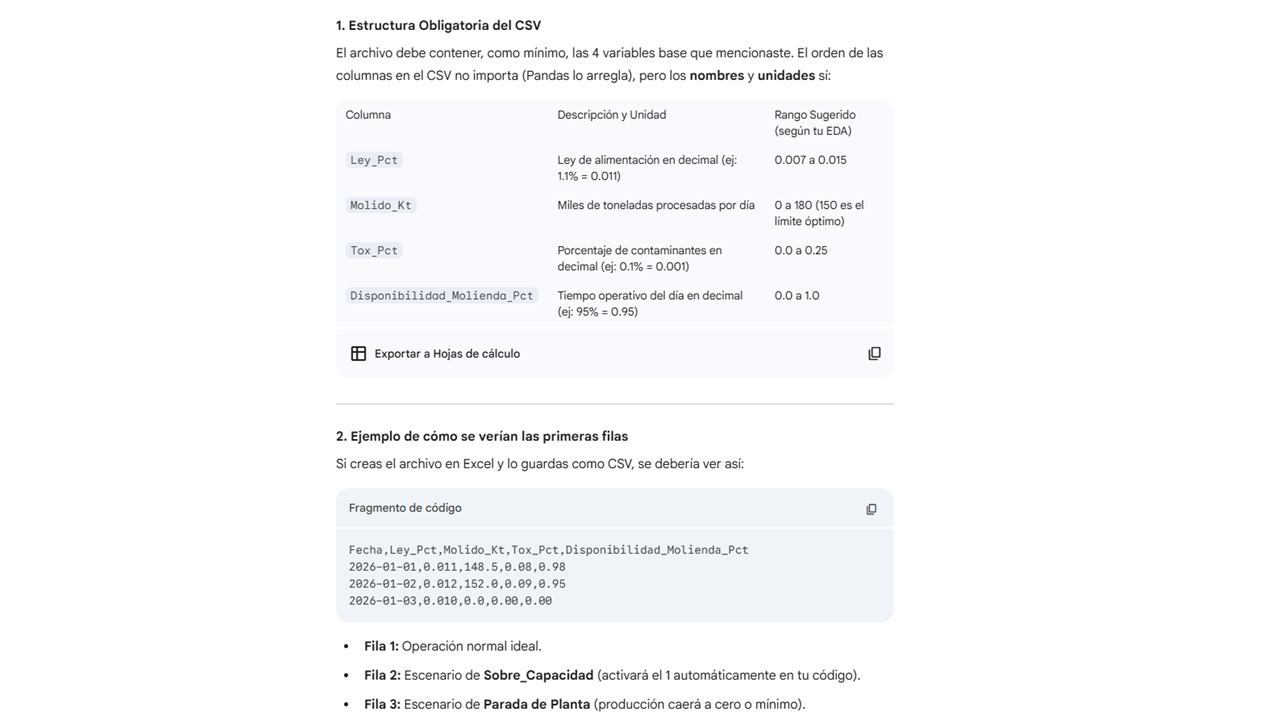

In [ ]:
## ejemplo para inputs de plan mensual
import pandas as pd
import numpy as np

# Configurar fechas para enero 2026
fechas = pd.date_range(start='2026-01-01', end='2026-01-31')

# Crear datos sintéticos pero realistas basados en tu EDA
data = {
    'Fecha': fechas,
    'Ley_Pct': np.random.uniform(0.009, 0.013, len(fechas)), # Ley entre 0.9% y 1.3%
    'Molido_Kt': np.random.uniform(140, 160, len(fechas)),   # Mezcla de días normales y sobre-capacidad
    'Tox_Pct': np.random.uniform(0.05, 0.12, len(fechas)),   # Niveles de contaminantes variables
    'Disponibilidad_Molienda_Pct': np.random.uniform(0.92, 0.99, len(fechas)) # Alta disponibilidad
}

df_plan = pd.DataFrame(data)

# Simular una Parada de Planta el 15 de enero (Día de mantenimiento)
df_plan.loc[df_plan['Fecha'] == '2026-01-15', ['Molido_Kt', 'Disponibilidad_Molienda_Pct', 'Tox_Pct']] = 0

# Guardar como CSV
df_plan.to_csv('plan_enero_2026.csv', index=False)
print("Archivo 'plan_enero_2026.csv' creado con éxito.")

In [ ]:
## aplicacion para plan mensual
import pandas as pd
import joblib
from google.colab import files
import io

# 1. Subir el archivo desde tu escritorio
print("Por favor, selecciona el archivo 'plan_enero_2026.csv' desde tu computadora:")
uploaded = files.upload()

# 2. Cargar el modelo (asegúrate de haber subido también el archivo .pkl a Colab)
# Puedes subir el .pkl usando la pestaña de archivos a la izquierda
modelo = joblib.load('modelo_produccion_cu_v2.pkl')

# 3. Leer el archivo cargado
nombre_archivo = list(uploaded.keys())[0]
plan_2026 = pd.read_csv(io.BytesIO(uploaded[nombre_archivo]))

# 4. Feature Engineering (Replicar la lógica del Modelo v2)
plan_2026['Ley_x_Tox'] = plan_2026['Ley_Pct'] * plan_2026['Tox_Pct']
plan_2026['Sobre_Capacidad'] = (plan_2026['Molido_Kt'] > 150).astype(int)

# 5. Ejecutar la predicción
features = ['Ley_Pct', 'Molido_Kt', 'Tox_Pct', 'Ley_x_Tox', 'Sobre_Capacidad', 'Disponibilidad_Molienda_Pct']
plan_2026['Prediccion_Fino_t'] = modelo.predict(plan_2026[features])

# 6. Mostrar resultados
total_enero = plan_2026['Prediccion_Fino_t'].sum()
print(f"\n--- RESULTADOS PARA {nombre_archivo} ---")
print(f"Producción Total Proyectada: {total_enero:,.2f} toneladas de Cu Fino")
display(plan_2026.head()) # Muestra las primeras filas con la predicción

In [ ]:
## aplicacion para plan mensual
# graficos
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Aseguramos que la columna 'Fecha' sea tipo datetime
plan_2026['Fecha'] = pd.to_datetime(plan_2026['Fecha'])

# 2. Crear la figura
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# --- GRÁFICO 1: Serie Temporal de Producción ---
ax1.plot(plan_2026['Fecha'], plan_2026['Prediccion_Fino_t'],
         marker='o', markersize=4, color='teal', label='Producción Proyectada (IA)')
ax1.fill_between(plan_2026['Fecha'],
                 plan_2026['Prediccion_Fino_t'] - 28.5,
                 plan_2026['Prediccion_Fino_t'] + 28.5,
                 color='teal', alpha=0.1, label='Margen de Error (MAE)')

ax1.set_title('Proyección Diaria de Producción de Cobre Fino - Enero 2026', fontsize=14)
ax1.set_ylabel('Toneladas de Cobre Fino')
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- GRÁFICO 2: Drivers (Molienda vs. Tóxicos) ---
ax2.bar(plan_2026['Fecha'], plan_2026['Molido_Kt'], color='gray', alpha=0.3, label='Molienda (Kt)')
ax2_twin = ax2.twinx()
ax2_twin.plot(plan_2026['Fecha'], plan_2026['Tox_Pct'], color='red', label='Nivel de Tóxicos (%)', linestyle='--')

ax2.set_ylabel('Molienda (Kt)')
ax2_twin.set_ylabel('Tóxicos (%)')
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')

# --- FORZAR ROTACIÓN DE FECHAS A 90 GRADOS ---
# Usamos setp para forzar la rotación en las etiquetas del eje X
plt.setp(ax2.get_xticklabels(), rotation=90, horizontalalignment='center')

# Formatear para que muestre cada día de enero
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Formato completo Año-Mes-Día
ax2.xaxis.set_major_locator(mdates.DayLocator()) # Un tick por cada día

plt.tight_layout()
plt.show()

In [ ]:
#proyeccion integral
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Asegurar formato datetime
plan_2026['Fecha'] = pd.to_datetime(plan_2026['Fecha'])

# 2. Crear panel de 3 gráficos
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 18), sharex=True)

# --- GRÁFICO 1: Producción Proyectada (Resultado) ---
ax1.plot(plan_2026['Fecha'], plan_2026['Prediccion_Fino_t'],
         marker='o', color='teal', linewidth=2, label='Producción IA (t)')
ax1.fill_between(plan_2026['Fecha'],
                 plan_2026['Prediccion_Fino_t'] - 28.5,
                 plan_2026['Prediccion_Fino_t'] + 28.5,
                 color='teal', alpha=0.1, label='Margen MAE')
ax1.set_title('1. Resultado: Proyección de Cobre Fino (ton)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Toneladas')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right')

# --- GRÁFICO 2: Calidad del Mineral (Ley vs Tóxicos) ---
ax2.plot(plan_2026['Fecha'], plan_2026['Ley_Pct'] * 100, color='blue', marker='s', label='Ley de Cu (%)')
ax2_twin = ax2.twinx()
ax2_twin.plot(plan_2026['Fecha'], plan_2026['Tox_Pct'], color='red', linestyle='--', label='Tóxicos (%)')
ax2.set_title('2. Calidad: Ley de Alimentación vs Concentración de Tóxicos', fontsize=14, fontweight='bold')
ax2.set_ylabel('Ley Cu (%)', color='blue')
ax2_twin.set_ylabel('Tóxicos (%)', color='red')
ax2.grid(True, alpha=0.3)

# --- GRÁFICO 3: Intensidad Operativa (Molienda) ---
ax3.bar(plan_2026['Fecha'], plan_2026['Molido_Kt'], color='gray', alpha=0.4, label='Molienda (Kt)')
ax3.axhline(150, color='orange', linestyle=':', label='Límite Sobre-Capacidad')
ax3.set_title('3. Operación: Tonelaje Molido y Límite de Eficiencia', fontsize=14, fontweight='bold')
ax3.set_ylabel('Kt/día')
ax3.legend(loc='upper left')

# --- FORZAR ROTACIÓN 90° Y FORMATO DE FECHAS ---
plt.setp(ax3.get_xticklabels(), rotation=90, horizontalalignment='center', fontsize=10)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax3.xaxis.set_major_locator(mdates.DayLocator())

plt.tight_layout()
plt.show()

In [ ]:
## proyeccion target para plan mensual
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Configurar metas (Basado en el promedio histórico del modelo)
prod_promedio_historica = 1455.0  # Valor central detectado en el modelo
target_operativo = 1480.0         # Meta de excelencia (superior al promedio)

# 2. Crear panel de 3 gráficos
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 20), sharex=True)

# --- GRÁFICO 1: Resultado con Metas ---
ax1.plot(plan_2026['Fecha'], plan_2026['Prediccion_Fino_t'],
         marker='o', color='teal', linewidth=2.5, label='Predicción IA (ton)')
ax1.fill_between(plan_2026['Fecha'],
                 plan_2026['Prediccion_Fino_t'] - 28.5,
                 plan_2026['Prediccion_Fino_t'] + 28.5,
                 color='teal', alpha=0.1, label='Margen MAE (±28.5t)')

# Añadir líneas de referencia
ax1.axhline(prod_promedio_historica, color='black', linestyle='--', alpha=0.6, label=f'Promedio Histórico ({prod_promedio_historica}t)')
ax1.axhline(target_operativo, color='green', linestyle='-', alpha=0.4, label=f'Target de Planta ({target_operativo}t)')

ax1.set_title('1. Resultado: Predicción de Producción vs Metas', fontsize=15, fontweight='bold')
ax1.set_ylabel('Cobre Fino (ton)')
ax1.legend(loc='upper right', frameon=True)
ax1.grid(True, alpha=0.2)

# --- GRÁFICO 2: Calidad del Mineral (Ley vs Tóxicos) ---
ax2.plot(plan_2026['Fecha'], plan_2026['Ley_Pct'] * 100, color='blue', marker='s', label='Ley de Cu (%)')
ax2_twin = ax2.twinx()
ax2_twin.plot(plan_2026['Fecha'], plan_2026['Tox_Pct'], color='red', linestyle='--', label='Tóxicos (%)')
ax2.set_title('2. Calidad: Impacto de Ley y Contaminantes', fontsize=15, fontweight='bold')
ax2.set_ylabel('Ley Cu (%)', color='blue')
ax2_twin.set_ylabel('Tóxicos (%)', color='red')
ax2.grid(True, alpha=0.2)

# --- GRÁFICO 3: Intensidad Operativa (Molienda) ---
ax3.bar(plan_2026['Fecha'], plan_2026['Molido_Kt'], color='gray', alpha=0.4, label='Molienda (Kt)')
ax3.axhline(150, color='orange', linestyle='-', linewidth=2, label='Límite de Eficiencia (150 Kt)')
ax3.set_title('3. Operación: Tonelaje y Límite de Capacidad', fontsize=15, fontweight='bold')
ax3.set_ylabel('Kt/día')
ax3.legend(loc='upper left')

# --- ROTACIÓN DE FECHAS A 90 GRADOS (ASEGURADA) ---
plt.setp(ax3.get_xticklabels(), rotation=90, horizontalalignment='center', fontsize=10)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax3.xaxis.set_major_locator(mdates.DayLocator())

plt.tight_layout()
plt.show()

In [ ]:
## cumplimiento y dias criticos
# 1. Calcular métricas de cumplimiento
dias_totales = len(plan_2026)
dias_cumplidos = len(plan_2026[plan_2026['Prediccion_Fino_t'] >= target_operativo])
pct_cumplimiento = (dias_cumplidos / dias_totales) * 100

# 2. Identificar los 3 días con mayor impacto negativo por Tóxicos
# (Días donde la Ley es buena pero la producción cae)
plan_2026['Impacto_Toxicos'] = plan_2026['Tox_Pct'] * plan_2026['Ley_Pct']
dias_criticos = plan_2026.sort_values(by='Tox_Pct', ascending=False).head(3)

print(f"--- RESUMEN EJECUTIVO: ENERO 2026 ---")
print(f"Cumplimiento del Target Operativo: {pct_cumplimiento:.1f}% ({dias_cumplidos} de {dias_totales} días)")
print(f"Producción Acumulada Proyectada: {plan_2026['Prediccion_Fino_t'].sum():,.2f} toneladas")
print(f"\n--- ALERTAS: DÍAS CON MAYOR CARGA DE TÓXICOS ---")
display(dias_criticos[['Fecha', 'Ley_Pct', 'Tox_Pct', 'Prediccion_Fino_t']])